# Testing out embedding + clustering

## Import dataset

In [24]:
from roboflow import Roboflow
import os
import umap

In [32]:
robo_workspace = "cyclinghelper"
robo_project = "pro-cyclist-teams"
robo_version = 1
robo_api_key = os.getenv("ROBOFLOW_API_KEY")

In [39]:
rf = Roboflow(api_key=robo_api_key)
project = rf.workspace(robo_workspace).project(robo_project)
version = project.version(robo_version)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...
Exporting format folder in progress : 85.0%
Version export complete for folder format


Python(27774) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Extracting Dataset Version Zip to pro-cyclist-teams-1 in folder:: 100%|██████████| 174/174 [00:00<00:00, 6075.77it/s]


## Clip Embeddings and Visualize

In [2]:
# Adapted from this notebook - https://colab.research.google.com/drive/1EJFpca6IG8dPCZ2-WwEX5GTDetp1Pe7f?usp=sharing#scrollTo=0OwO0H8UMIA7

import torch
import clip
from PIL import Image
import cv2
import base64
import glob
import numpy as np
import os
import umap
import time

model_name='ViT-B/32'

# MPS for apple - switch to CUDA later if I use a GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")
# device='cpu'

openai_clip_model, openai__preprocess = clip.load(model_name,device)

def get_openai_clip_embedding(imgs):
  with torch.no_grad():
    preprocessed = torch.stack([openai__preprocess(i) for i in imgs]).to(device)
    features = openai_clip_model.encode_image(preprocessed)
    features /= features.norm(dim=-1, keepdim=True)
    return features[0]

tensor([1.], device='mps:0')


In [3]:
e = get_openai_clip_embedding([Image.open('crops/Gent Wevelgem 2024_image_3.jpg')])
e.cpu().numpy().shape

(512,)

In [4]:
# Create embeddings and align with labels and images
def image_to_data_uri(image_path):
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
    return "data:image/jpeg;base64," + encoded_image

SOURCE_DIR = 'pro-cyclist-teams-1/test/'

labels = []
openclip_embeddings = []
openai_clip_embeddings = []
train = []
images = []
image_paths = []

class_ids = sorted(os.listdir(SOURCE_DIR))

for class_id in class_ids:
    source_subdir = os.path.join(SOURCE_DIR, class_id)
    for image_path in glob.glob(source_subdir+'/*.jpg'):
      try:
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        img = Image.open(image_path)
        openai_clip_emb = get_openai_clip_embedding([img])
        openai_clip_embeddings.append(openai_clip_emb.cpu().numpy())
        labels.append(class_id)
        images.append(image)
        image_paths.append(str(image_path))
      except:
        print(f"can't process {image_path}")
        pass

# class associated with image
labels = np.array(labels)
# features extracted from image
openai_clip_embeddings = np.array(openai_clip_embeddings)


# local image path
image_paths = np.array(image_paths)
# cached images
image_data_uris = {path: image_to_data_uri(path) for path in image_paths}

In [5]:
%load_ext autoreload
%autoreload 2
from utils import plotting

In [6]:
openai_clip_embeddings

array([[ 0.01009 ,  0.006256, -0.01976 , ...,  0.003696,  0.007523,
         0.001733],
       [ 0.01406 ,  0.014915, -0.005646, ...,  0.02266 , -0.02524 ,
        -0.007557],
       [-0.01642 , -0.00876 ,  0.01397 , ...,  0.0635  , -0.00202 ,
         0.002066],
       ...,
       [ 0.00821 ,  0.00722 , -0.00666 , ...,  0.01    ,  0.0171  ,
        -0.00422 ],
       [ 0.001149,  0.01515 , -0.01631 , ..., -0.003628,  0.0251  ,
        -0.016   ],
       [ 0.03406 ,  0.00902 ,  0.007484, ..., -0.01562 ,  0.01796 ,
        -0.01353 ]], dtype=float16)

In [7]:
start = time.time()
projections = umap.UMAP(n_components=3).fit_transform(openai_clip_embeddings)
end = time.time()
print(f"generating projections with UMAP took: {(end-start):.2f} sec")
html_template = plotting.plot_3D_projection_html(
    labels=labels,
    projections=projections,
    image_paths=image_paths,
    image_data_uris=image_data_uris
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


generating projections with UMAP took: 2.83 sec


In [8]:
# Specify the filename
filename = 'test_template.html'

# Open the file in write mode and save the HTML template
with open(filename, 'w') as file:
    file.write(html_template)

print(f"HTML template saved as {filename}")

HTML template saved as test_template.html


generating projections with UMAP took: 0.85 sec


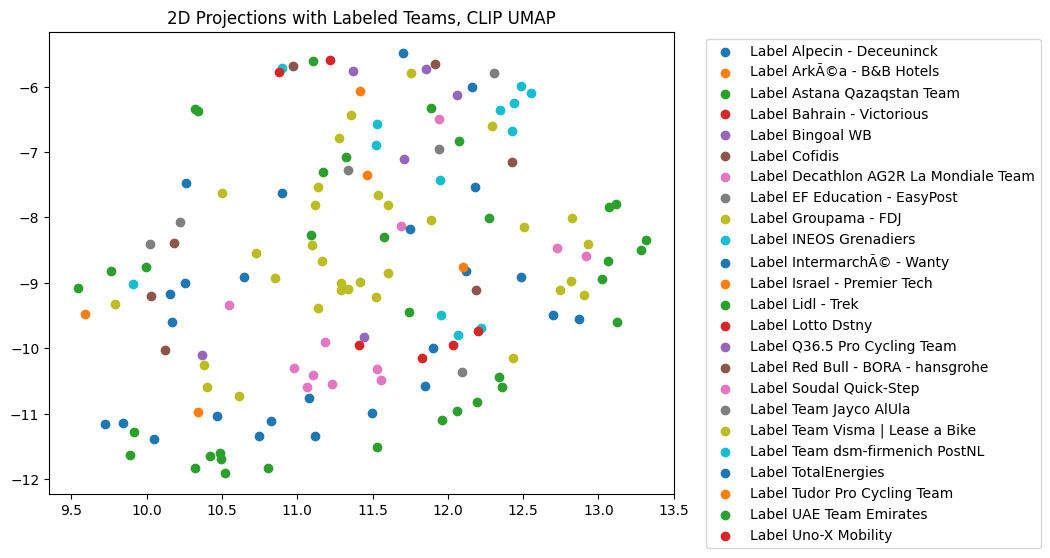

In [9]:
start = time.time()
projections = umap.UMAP(n_components=2).fit_transform(openai_clip_embeddings)
end = time.time()
print(f"generating projections with UMAP took: {(end-start):.2f} sec")
plotting.plot_2D_projection(labels, projections, True, ", CLIP UMAP")

Right now there is a little clustering, but really very little separation between the teams.

I think the next step is to train a classifier to tell between these teams; then we should be able to use embeddings from that model to cluster better and hopefully the clustering generalizes to teams outside the dataset.

# Old

In [ ]:
import YOLO
# Test out the trained model on video snippets
model = 'models/best.pt'
video = 'video_snippets/Gent Wevelgem 2024_snippet_2.mp4'

model = YOLO(model)
model.predict(video, save=True,conf=0.8)